# Analysis on a party
What we want to do here is work with our *voting_with_topics.csv* file, which records the votes that every person made with respect to each subjet. We want to train a model and see whether, given a new text of law, our model will successfully be able to predict what a person would have voted. We will start by exploring our data first.

## 1.0 - Imports, Loading and Formatting of the Data

- Voting profile of party/individual -> Statistical test to see whether a party is more often voting yes to a topic.
- Individual : See how the profile fits the party.
 
 
 DF1 : Text | Decision | Topic 
 Initial DF -> Topic of text added.
 
 Other DF : Text -> Topic -> Person as index and decision 


In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve
import sklearn.metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

Importing the quite heavy DataFrame with the voting fields and the results. We drop a useless column and create a *Name* field, which will contain both the first and the last name of a person, so we can then create a model for each unique deputee at the parliament. 

In [2]:
path = '../datas/nlp_results/'
voting_df = pd.read_csv(path+'voting_with_topics.csv')
print('Entries in the DataFrame',voting_df.shape)


#Putting numerical values into the columns that should have numerical values

num_cols = ['Unnamed: 0','BusinessNumber','BillTitle', 'BusinessTitle','FirstName','LastName', 'BusinessShortNumber', 
            'Canton', 'CantonID','CantonName', 'DecisionText', 'ID', 'IdLegislativePeriod',
            'IdSession', 'IdVote', 'Language', 'MeaningNo', 'MeaningYes', 'ParlGroupColour', 
            'ParlGroupNameAbbreviation', 'PersonNumber', 'RegistrationNumber']

cols_number = ['Decision', ' armée', ' asile / immigration', ' assurances',
       ' budget', ' dunno', ' entreprise/ finance', ' environnement',
       ' famille / enfants', ' imposition', ' politique internationale',
       ' retraite  ']
voting = voting_df.drop(num_cols,axis=1)
voting[cols_number] = voting[cols_number].apply(pd.to_numeric)
# Readding the text because it is not numeric
#Inserting the full name at the second position
voting.insert(1,'Name', voting_df['FirstName'] + ' ' + voting_df['LastName'])
voting.head(3)

Entries in the DataFrame (1713854, 39)


,Decision,Name,ParlGroupCode,ParlGroupName,Subject,VoteEnd,text,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite
0,7,Chiara Simoneschi-Cortesi,CEg,Groupe conservateur-catholique,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
1,5,Pascale Bruderer Wyss,S,Groupe socialiste,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
2,5,Guy Parmelin,V,"Groupe des Paysans, Artisans et Bourgeois",Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993


Visualising all the different parties, along with their names. Note that for the same party, there are several same group codes. We will then use the `ParlGroupName` field over the `ParlGroupCode`

In [3]:
voting[['ParlGroupCode','ParlGroupName']].drop_duplicates()

,ParlGroupCode,ParlGroupName
0,CEg,Groupe conservateur-catholique
1,S,Groupe socialiste
2,V,"Groupe des Paysans, Artisans et Bourgeois"
3,RL,Groupe radical-démocratique
12,G,Groupe écologiste
65,BD,Groupe BD
52202,GL,Groupe vert'libéral
52205,CE,Groupe conservateur-catholique
55450,-,Non inscrit
838285,C,Groupe conservateur-catholique


The first reduction of our DataFrame is to suppress all the entries of the *Decision* field, which contain either a *4*, a *5*, a *6* or a *7*. It basically means that the person did not take part to the voting, and that is hence not useful to our purpose. 

In [4]:
voting_df = voting[((voting.Decision != 4) & (voting.Decision != 5) & (voting.Decision != 6) & (voting.Decision != 7))]
print(voting_df.shape)
#print('Top number of entries in the df :\n', voting_df.Name.value_counts())

(1536877, 18)


We also drop the duplicates in the votes, keeping only the last one. Plot first an example of vote of a subject (Guy Parmelin) 

In [5]:
gp = voting.loc[voting.Name=='Guy Parmelin']
gpt = gp.loc[gp.text == "Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie"]
gpt[['Decision','VoteEnd']]

,Decision,VoteEnd
2,5,2009-09-07T15:44:26.69
202,2,2009-09-07T15:50:17.32
402,2,2009-09-07T15:51:51.893
602,2,2009-09-07T16:07:41.08
802,2,2009-09-07T16:24:34.93
1002,1,2009-09-07T16:39:58.43
1202,2,2009-09-07T16:41:02.057


Drop duplicates here

In [6]:
voting_unique = voting_df.drop_duplicates(['text','Name'], keep = 'last')
voting_unique.head()

,Decision,Name,ParlGroupCode,ParlGroupName,Subject,VoteEnd,text,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite
400,1,Chiara Simoneschi-Cortesi,CEg,Groupe conservateur-catholique,Art. 1 (frein aux dépenses),2009-09-07T15:51:51.893,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
474,1,Hans Stöckli,S,Groupe socialiste,Art. 1 (frein aux dépenses),2009-09-07T15:51:51.893,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
529,1,Philipp Müller,RL,Groupe radical-démocratique,Art. 1 (frein aux dépenses),2009-09-07T15:51:51.893,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
565,2,Ulrich Giezendanner,V,"Groupe des Paysans, Artisans et Bourgeois",Art. 1 (frein aux dépenses),2009-09-07T15:51:51.893,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
593,2,Max Binder,V,"Groupe des Paysans, Artisans et Bourgeois",Art. 1 (frein aux dépenses),2009-09-07T15:51:51.893,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993


One element left below for a given people and entry. We will work with the `voting_unique` df.

In [7]:
gp = voting_unique.loc[voting.Name=='Guy Parmelin']
gpt = gp.loc[gp.text == "Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie"]
gpt[['Decision','VoteEnd']]

,Decision,VoteEnd
1202,2,2009-09-07T16:41:02.057


Merging our DataFrame with the one containing the informations on each text

In [8]:

# Additional infos : whether the text was accepted and most proeminent topic
text_votes = pd.read_csv('topic_accepted.csv')
# Merging both DataFrames on the text field
voting_unique = pd.merge(voting_unique, text_votes, on=['text', 'text'])

In [9]:
def format_party_voting_profile(voting_unique):
     
    # Setting the desired multiIndex
    voting_party = voting_unique.set_index(['ParlGroupName','Topic'])[['Decision']]
    
    #2. Counting yes/no/abstention
    
    # Splitting the df by each party and topic, and then aggregating by yes/no/abstention 
    # Normalising every entry
    count_yes = lambda x: np.sum(x==1)/(len(x))
    count_no = lambda x: np.sum(x==2)/(len(x))
    count_abstention = lambda x: np.sum(x==3)/(len(x))

    voting_party = voting_party.groupby(level=['ParlGroupName','Topic']).agg({'Decision':
                                  {'Yes': count_yes, 'No': count_no,'Abstention': count_abstention}})

    voting_party.columns = voting_party.columns.droplevel(0)
    
    return voting_party

Formatting the `voting_party` DF

In [10]:
#voting_party = voting_party.unstack()
#voting_party.columns = voting_party.columns.swaplevel(1, 2)
#voting_party.sortlevel(0,axis=1,inplace=True)

In [11]:
voting_party = format_party_voting_profile(voting_unique)
voting_party.head()

No       Yes  Abstention
ParlGroupName Topic                                               
Groupe BD      armée                0.390098  0.587430    0.022472
               asile / immigration  0.241819  0.745746    0.012435
               assurances           0.435410  0.533115    0.031475
               budget               0.362818  0.617240    0.019942
               dunno                0.382832  0.598696    0.018472

### Some statistics about the whole DF.

Retrieve all topics and parties

In [12]:
parties = voting_party.index.get_level_values('ParlGroupName').unique()
topics = voting_party.index.get_level_values('Topic').unique()
topics

array([' armée', ' asile / immigration', ' assurances', ' budget',
       ' dunno', ' entreprise/ finance', ' environnement',
       ' famille / enfants', ' imposition', ' politique internationale',
       ' retraite  '], dtype=object)

Extremal percentages (Yes/No)

In [13]:
for topic in topics:
    topic_voting_party = voting_party.xs(topic, level='Topic', drop_level=True)
    
    max_yes = topic_voting_party.Yes.max().round(2); idx_max_yes = topic_voting_party.Yes.idxmax(); 
    max_no = topic_voting_party.No.max().round(2); idx_max_no = topic_voting_party.No.idxmax()

    min_yes = topic_voting_party.Yes.min().round(2); idx_min_yes = topic_voting_party.Yes.idxmin()
    min_no = topic_voting_party.No.min().round(2);    idx_min_no = topic_voting_party.No.idxmin()

    print('Topic :',topic,'\n\t MAX YES :',idx_max_yes,'(',max_yes,')','\t  MAX NO :',idx_max_no,'(',max_no,')')
    print('\t MIN YES :',idx_min_yes,'(',min_yes,')','\t  MIN NO :',idx_min_no,'(',min_no,')')

Topic :  armée 
	 MAX YES : Non inscrit ( 0.59 ) 	  MAX NO : Groupe des Paysans, Artisans et Bourgeois ( 0.47 )
	 MIN YES : Groupe des Paysans, Artisans et Bourgeois ( 0.51 ) 	  MIN NO : Groupe conservateur-catholique ( 0.39 )
Topic :  asile / immigration 
	 MAX YES : Groupe vert'libéral ( 0.79 ) 	  MAX NO : Groupe des Paysans, Artisans et Bourgeois ( 0.55 )
	 MIN YES : Groupe des Paysans, Artisans et Bourgeois ( 0.42 ) 	  MIN NO : Groupe écologiste ( 0.2 )
Topic :  assurances 
	 MAX YES : Groupe vert'libéral ( 0.57 ) 	  MAX NO : Groupe des Paysans, Artisans et Bourgeois ( 0.5 )
	 MIN YES : Groupe radical-démocratique ( 0.47 ) 	  MIN NO : Groupe conservateur-catholique ( 0.39 )
Topic :  budget 
	 MAX YES : Non inscrit ( 0.65 ) 	  MAX NO : Groupe des Paysans, Artisans et Bourgeois ( 0.52 )
	 MIN YES : Groupe des Paysans, Artisans et Bourgeois ( 0.47 ) 	  MIN NO : Non inscrit ( 0.32 )
Topic :  dunno 
	 MAX YES : Non inscrit ( 0.63 ) 	  MAX NO : Groupe des Paysans, Artisans et Bourgeois (

### Extracting a party

The function below allows us to select one party and extract the DataFrame from the whole DataFrame

In [18]:
party_vote = voting_party.xs('Groupe des Paysans, Artisans et Bourgeois', level='ParlGroupName', drop_level=True)
party_vote.Yes

Topic
 armée                       0.514307
 asile / immigration         0.415206
 assurances                  0.480535
 budget                      0.469614
 dunno                       0.519924
 entreprise/ finance         0.479698
 environnement               0.427393
 famille / enfants           0.542446
 imposition                  0.508549
 politique internationale    0.558696
 retraite                    0.489602
Name: Yes, dtype: float64

## 2.0 Dealing with a single individual at a time.
### 2.1 Formatting the DF

In [14]:
def format_individual_voting_profile(voting_unique):

    # Setting Name, Party and Topic as indices
    voting_deputee = voting_unique.set_index(['Name','ParlGroupName','Topic'])[['Decision']]
    
    # Functions to count number of yes/no/absentions, same principle as before
    count_yes = lambda x: np.sum(x==1)/(len(x))
    count_no = lambda x: np.sum(x==2)/(len(x))
    count_abstention = lambda x: np.sum(x==3)/(len(x))

    voting_deputee = voting_deputee.groupby(level=['ParlGroupName','Name','Topic']).agg({'Decision':
                                  {'Yes': count_yes, 'No': count_no,'Abstention': count_abstention}})
    voting_deputee.columns = voting_deputee.columns.droplevel(0)
    
    return voting_deputee

In [15]:
voting_deputee = format_individual_voting_profile(voting_unique)
voting_deputee.head()

No       Yes  \
ParlGroupName Name          Topic                                      
Groupe BD     Bernhard Guhl  armée                0.358974  0.611722   
                             asile / immigration  0.226950  0.751773   
                             assurances           0.404255  0.560284   
                             budget               0.373288  0.595890   
                             dunno                0.391473  0.581395   

                                                  Abstention  
ParlGroupName Name          Topic                             
Groupe BD     Bernhard Guhl  armée                  0.029304  
                             asile / immigration    0.021277  
                             assurances             0.035461  
                             budget                 0.030822  
                             dunno                  0.027132

### 2.2 Retrieving the stats w.r.t to the party for each individual

In [19]:
def compute_party_distance(voting_deputee,voting_party):
    
    # Retrieve the unique parties and topics
    parties = voting_party.index.get_level_values('ParlGroupName').unique()
    topics = voting_party.index.get_level_values('Topic').unique()
    
    # Extract the features of each party in a more convenient and easily accessible fashion
    party_vote_dict = {}
    for party in parties:
        party_vote_dict[party] = voting_party.xs(party, level='ParlGroupName', drop_level=True)
        for topic in topics:
            split_df = voting_deputee.loc[(party,slice(None),topic),:]
            
            split_df.loc[(party,slice(None),topic),'Yes'] = split_df.apply(lambda x: x-party_vote_dict[party].Yes[topic])
            split_df.loc[(party,slice(None),topic),'No'] = split_df.apply(lambda x: x-party_vote_dict[party].No[topic])
            split_df.loc[(party,slice(None),topic),'Abstention'] = split_df.apply(lambda x: x-party_vote_dict[party].Abstention[topic])
    
            voting_deputee.loc[(party,slice(None),topic),:] = split_df
    return voting_deputee

voting_deputee_party = compute_party_distance(voting_deputee,voting_party)

/home/thomas/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### 2.3 Plotting the stats w.r.t to the party for each individual

In [20]:
def plot_df(df,item,topic):
    
    #Setting the size of the plots
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 25
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size
    
    df_item = df.sort_values(item,ascending=False)
    y = np.array(df_item[item])

    plt.bar(range(df_item.shape[0]), df_item[item], align='center', tick_label=df_item.index)
    plt.ylabel("Deviation from"+item+"mean of party\n item :"+ topic)

    plt.xticks(rotation=90, ha='left')
    plt.xlabel("Deputee")
    
    plt.show()

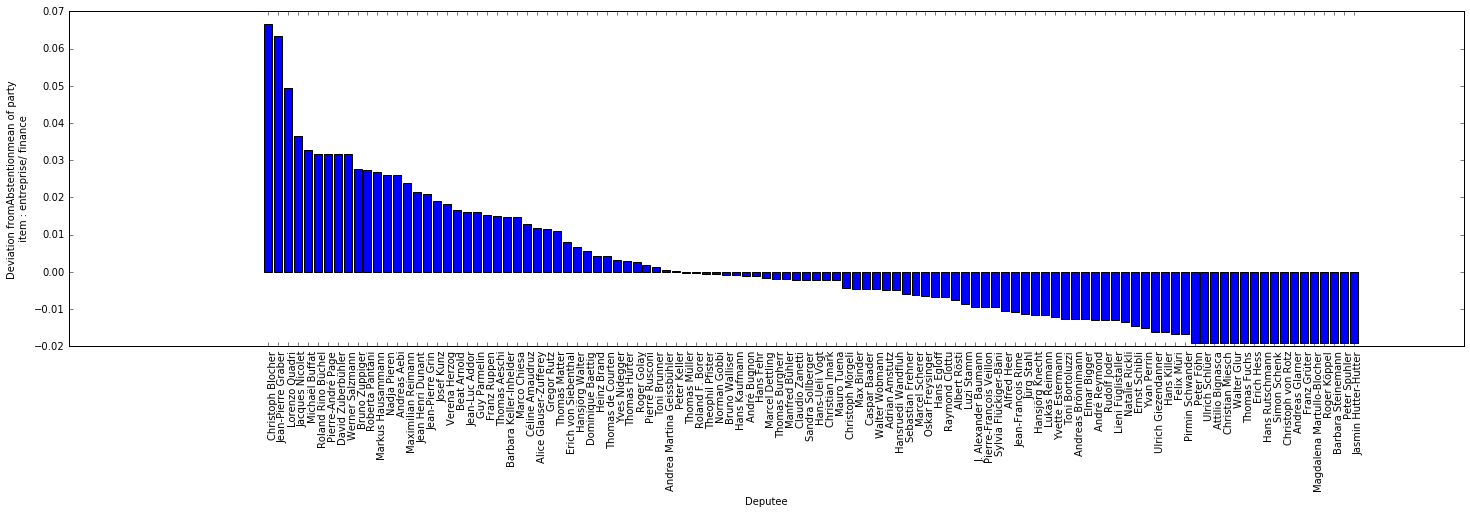

In [26]:
party = 'Groupe des Paysans, Artisans et Bourgeois'
test = voting_deputee.xs((party,topics[5]),level=('ParlGroupName','Topic'),drop_level=True).sort_values('Yes',ascending=False)
plot_df(test,'Abstention',topics[5])

### 2.4 Computing the stats w.r.t to the party for each individual while aggregating all topics

In [27]:
voting_deputee_party.head()

No       Yes  \
ParlGroupName Name          Topic                                      
Groupe BD     Bernhard Guhl  armée               -0.031124  0.024292   
                             asile / immigration -0.014869  0.006027   
                             assurances          -0.031155  0.027169   
                             budget               0.010470 -0.021350   
                             dunno                0.008641 -0.017301   

                                                  Abstention  
ParlGroupName Name          Topic                             
Groupe BD     Bernhard Guhl  armée                  0.006832  
                             asile / immigration    0.008842  
                             assurances             0.003986  
                             budget                 0.010880  
                             dunno                  0.008660

In [34]:
def format_individual_global_voting_profile(voting_unique):
     
    # Setting the desired multiIndex
    voting_indiv = voting_unique.set_index(['ParlGroupName','Name'])[['Decision']]
    
    #2. Counting yes/no/abstention
    
    # Splitting the df by each party and topic, and then aggregating by yes/no/abstention 
    # Normalising every entry
    count_yes = lambda x: np.sum(x==1)/(len(x))
    count_no = lambda x: np.sum(x==2)/(len(x))
    count_abstention = lambda x: np.sum(x==3)/(len(x))

    voting_indiv = voting_indiv.groupby(level=['ParlGroupName','Name']).agg({'Decision':
                                  {'Yes': count_yes, 'No': count_no,'Abstention': count_abstention}})

    voting_indiv.columns = voting_indiv.columns.droplevel(0)
    
    return voting_indiv

def format_party_global_profile(voting_unique):

    #2. Counting yes/no/abstention
    
    # Splitting the df by each party and topic, and then aggregating by yes/no/abstention 
    # Normalising every entry
    count_yes = lambda x: np.sum(x==1)/(len(x))
    count_no = lambda x: np.sum(x==2)/(len(x))
    count_abstention = lambda x: np.sum(x==3)/(len(x))

    overall_party = voting_unique.groupby('ParlGroupName').agg({'Decision':
                                  {'Yes': count_yes, 'No': count_no,'Abstention': count_abstention}})

    overall_party.columns = overall_party.columns.droplevel(0)
    
    return overall_party
voting_indiv = format_individual_global_voting_profile(voting_unique)
overall_party = format_party_global_profile(voting_unique)

In [35]:
voting_indiv.head()

No       Yes  Abstention
ParlGroupName Name                                               
Groupe BD     Bernhard Guhl        0.325159  0.647593    0.027248
              Brigitta M. Gadient  0.365353  0.606732    0.027915
              Duri Campell         0.358416  0.639604    0.001980
              Hans Grunder         0.355273  0.630545    0.014182
              Hansjörg Hassler     0.330673  0.658570    0.010756

In [36]:
overall_party.loc[overall_party.index == party]


,No,Yes,Abstention
ParlGroupName,,,
"Groupe des Paysans, Artisans et Bourgeois",0.493341,0.487234,0.019425


In [37]:
def compute_overall_party_distance(voting_indiv,overall_party):
    
    # Retrieve the unique parties and topics
    parties = voting_party.index.get_level_values('ParlGroupName').unique()    
    # Extract the features of each party in a more convenient and easily accessible fashion
    party_vote_dict = {}
    for party in parties:
        party_vote = overall_party.loc[overall_party.index == party]
        split_df = voting_indiv.loc[(party,slice(None)),:]
            
        split_df.loc[(party,slice(None)),'Yes'] = split_df.apply(lambda x: x-party_vote.Yes)
        split_df.loc[(party,slice(None)),'No'] = split_df.apply(lambda x: x-party_vote.No)
        split_df.loc[(party,slice(None)),'Abstention'] = split_df.apply(lambda x: x-party_vote.Abstention)
    
        voting_indiv.loc[(party,slice(None)),:] = split_df
    return voting_indiv

voting_indiv_party = compute_overall_party_distance(voting_indiv,overall_party)

/home/thomas/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
def plot_df_overall(df,item,party):
    
    #Setting the size of the plots
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 25
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size
    
    df_item = df.sort_values(item,ascending=False)
    y = np.array(df_item[item])

    plt.bar(range(df_item.shape[0]), df_item[item], align='center', tick_label=df_item.index)
    plt.ylabel("Deviation from "+item+"-mean of party")

    plt.xticks(rotation=90, ha='left')
    plt.xlabel("Deputees of " +party)
    
    plt.show()

In [39]:
voting_indiv_party.xs(('Groupe BD'),level=('ParlGroupName'),drop_level=True).head()

,No,Yes,Abstention
Name,,,
Bernhard Guhl,-0.011804,0.004157,0.007647
Brigitta M. Gadient,0.028390,-0.036703,0.008314
Duri Campell,0.021453,-0.003832,-0.017621
Hans Grunder,0.018310,-0.012890,-0.005419
Hansjörg Hassler,-0.006290,0.015135,-0.008845


In [40]:
map_parties = {'-':'-','BD':'PBD','C':'PDC','CE':'PDC','CEg':'PDC','G':'Verts','GL':'Verts-Lib','S':'PS','V':'UDC'}

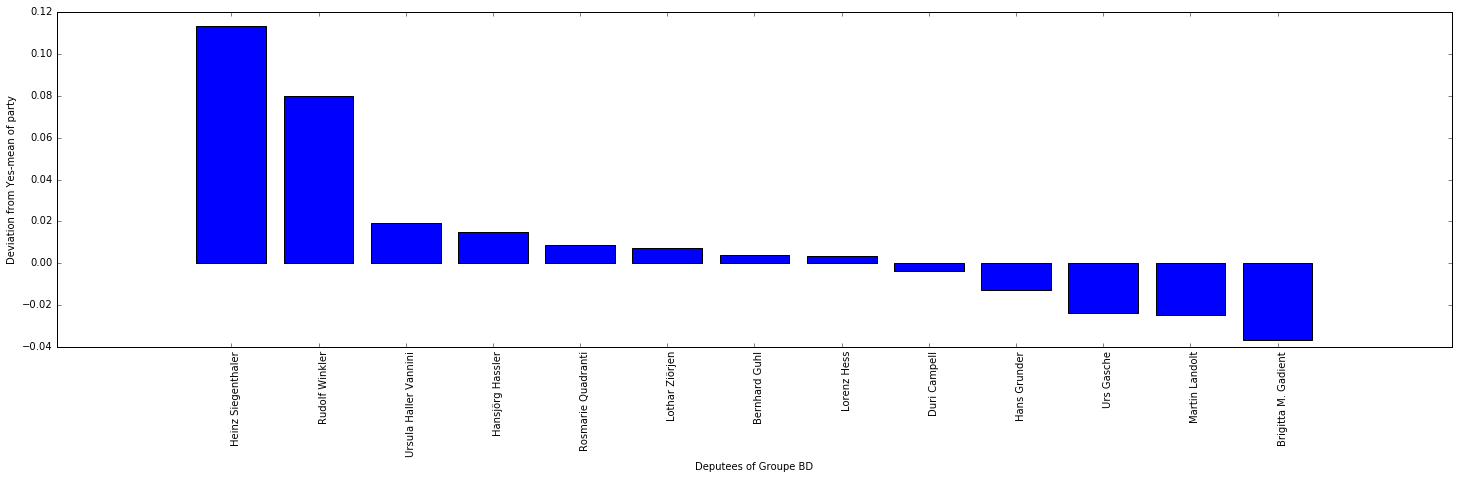

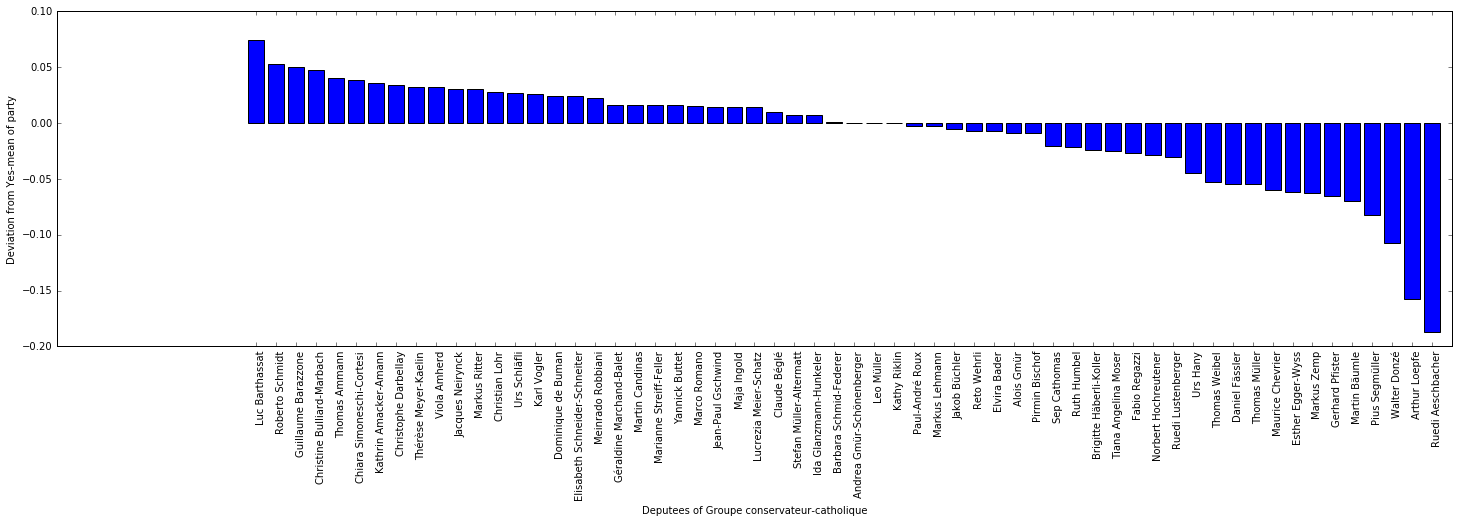

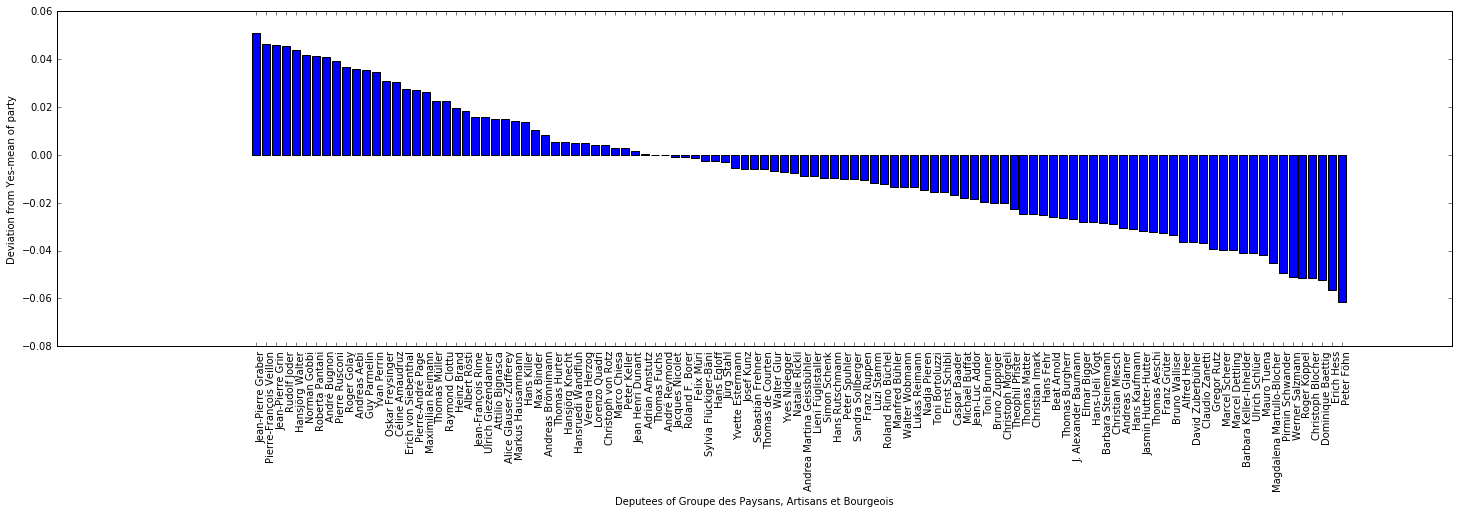

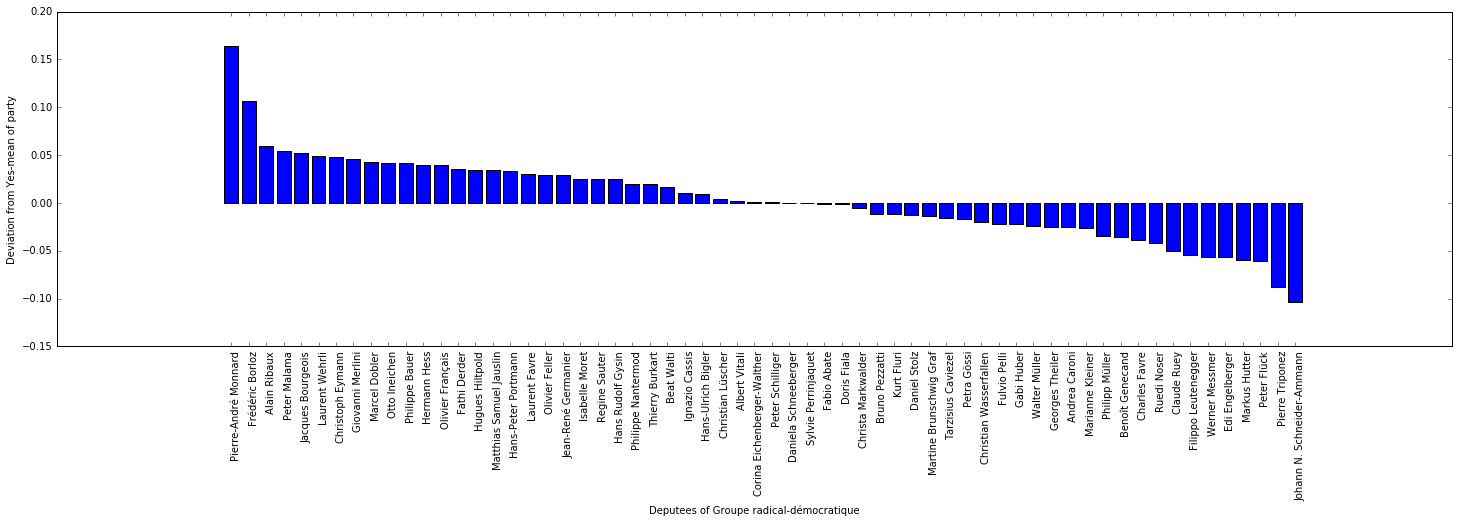

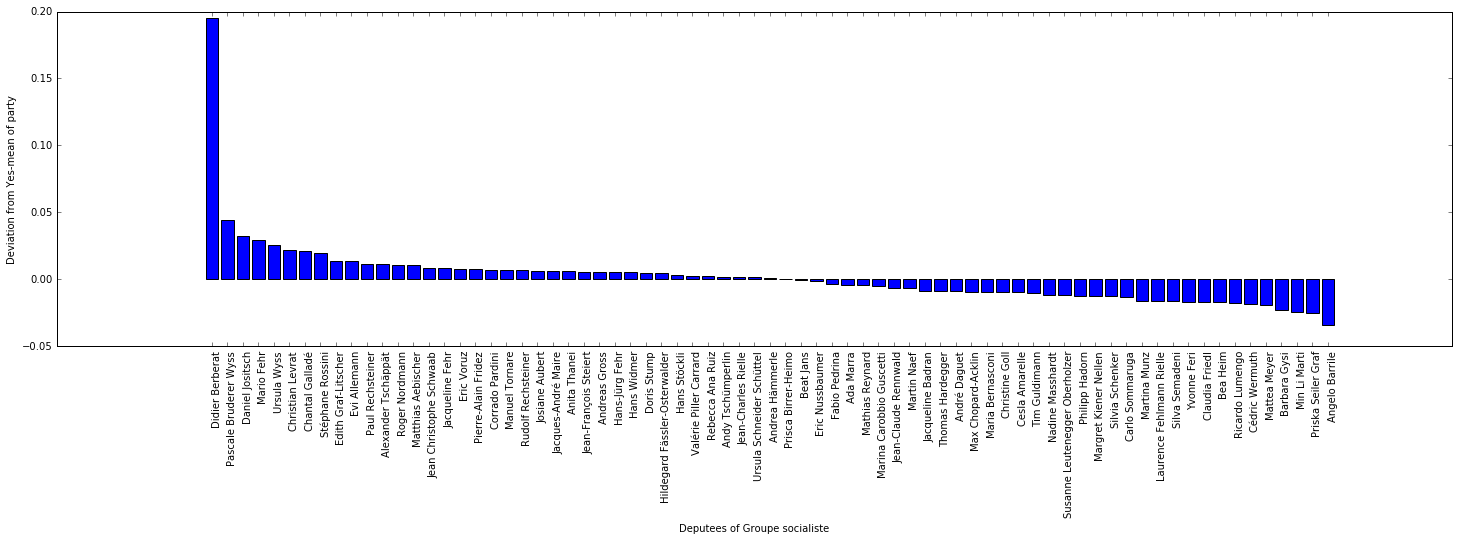

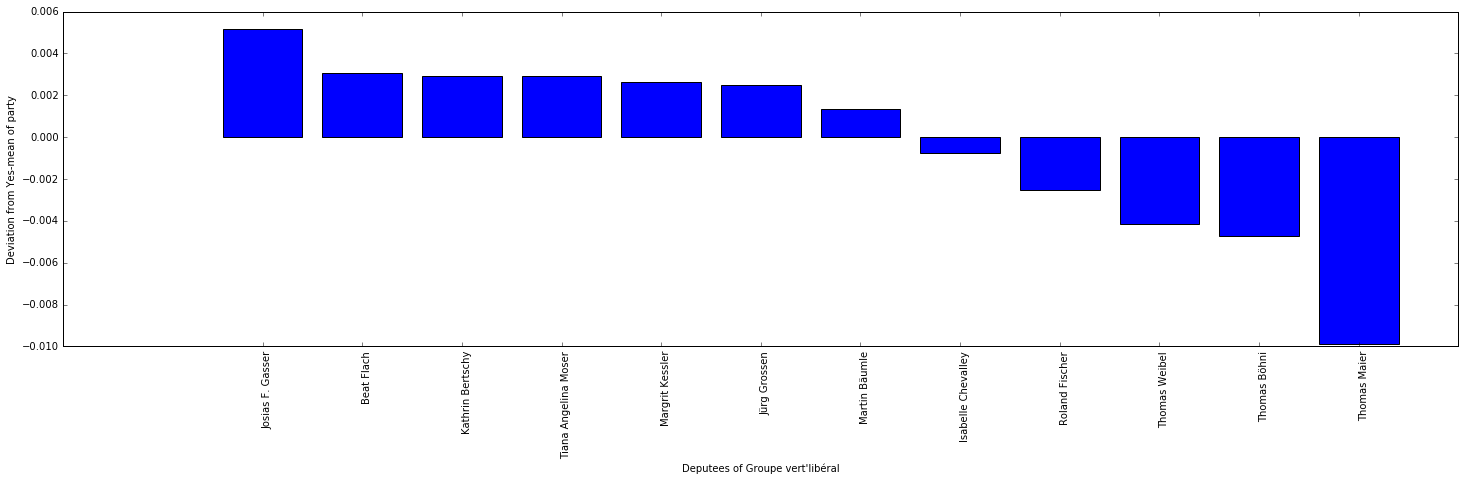

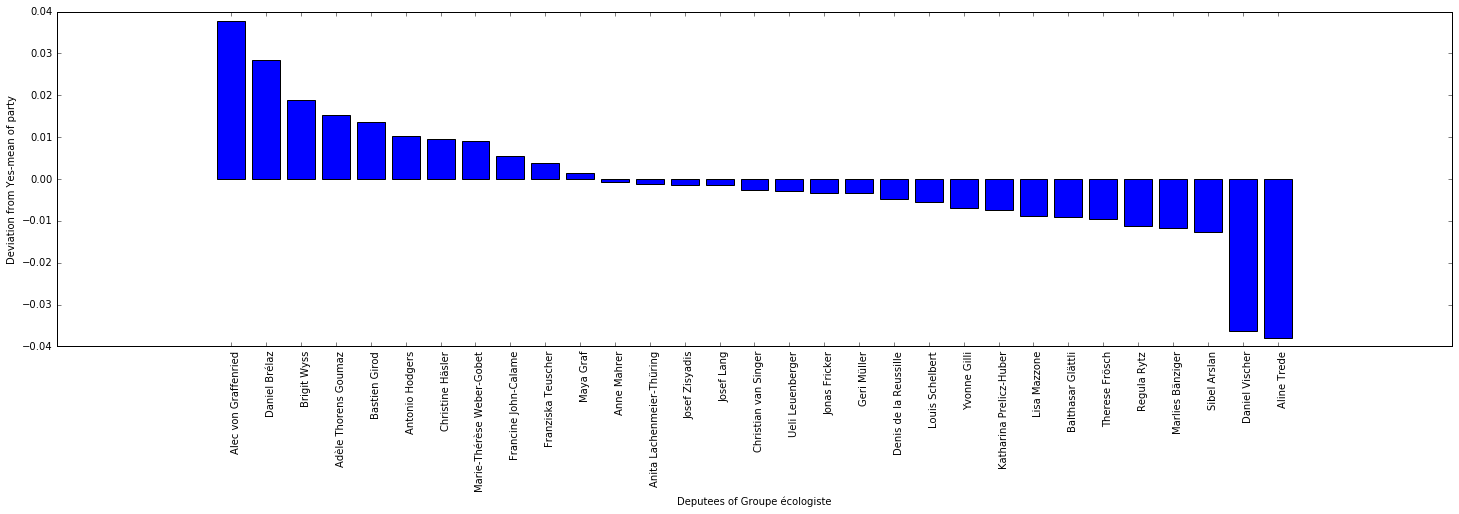

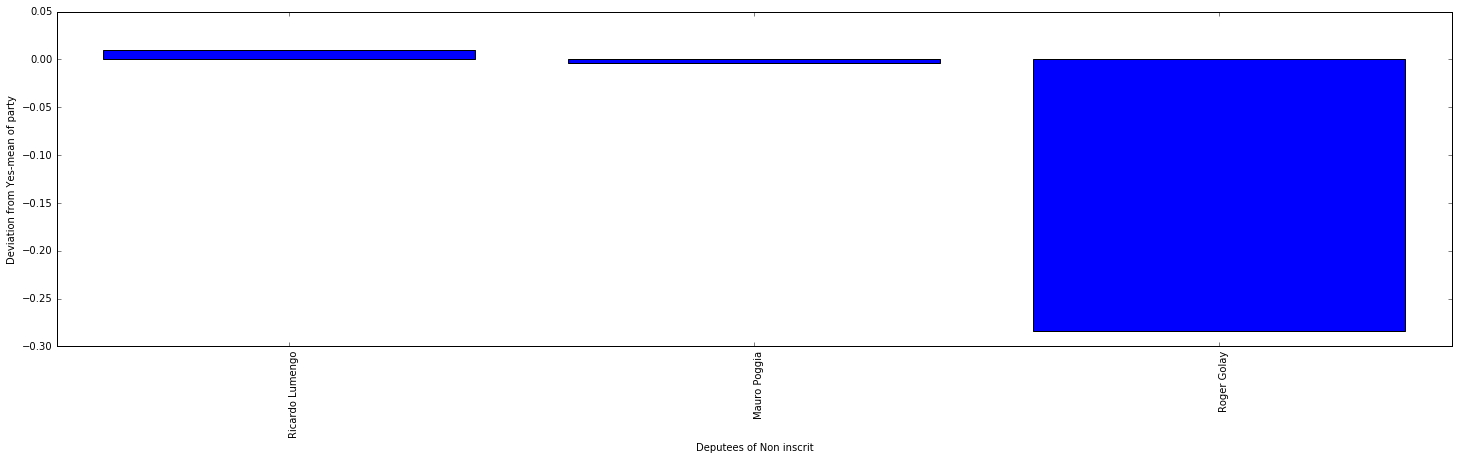

In [42]:
for party in parties:
    test = voting_indiv_party.xs((party),level=('ParlGroupName'),drop_level=True)
    plot_df_overall(test,'Yes',party)

This is not the greatest visualisation one could conceive, but we see that there are some consistent deviations in the behaviour of the people of a party of not doing as the rest of the party does, i.e. having a consistent yes-behaviour, or a consistent no-behaviour.